# Transfer Learning with MobileNetV2

We'll be using transfer learning on a pre-trained CNN to build an Alpaca/Not Alpaca classifier!

<img src="media/alpaca.png" style="width:300px;height:220px;">

A pre-trained model is a network that's already been trained on a large dataset and saved, which allows us to use it to customize our own model cheaply and efficiently. The one we'll be using, MobileNetV2, was designed to provide fast and computationally efficient performance. It's been pre-trained on ImageNet, a dataset containing over 14 million images and 1000 classes.

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

## Create the Dataset and Split it into Training and Validation Sets

When training and evaluating deep learning models in Keras, generating a dataset from image files stored on disk is simple and fast. Call `image_data_set_from_directory()` to read from the directory and create both training and validation datasets. 

If specifying a validation split, we'll also need to specify the subset for each portion. Just set the training set to `subset='training'` and the validation set to `subset='validation'`.

We'll also set seeds to match each other, so your training and validation sets don't overlap.

In [2]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

directory = "dataset/"
train_dataset = image_dataset_from_directory(directory, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE,
                                             validation_split=0.2, subset='training', seed=42)

validation_dataset = image_dataset_from_directory(directory, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE,
                                             validation_split=0.2, subset='validation', seed=42)

Found 327 files belonging to 2 classes.
Using 262 files for training.
Found 327 files belonging to 2 classes.
Using 65 files for validation.


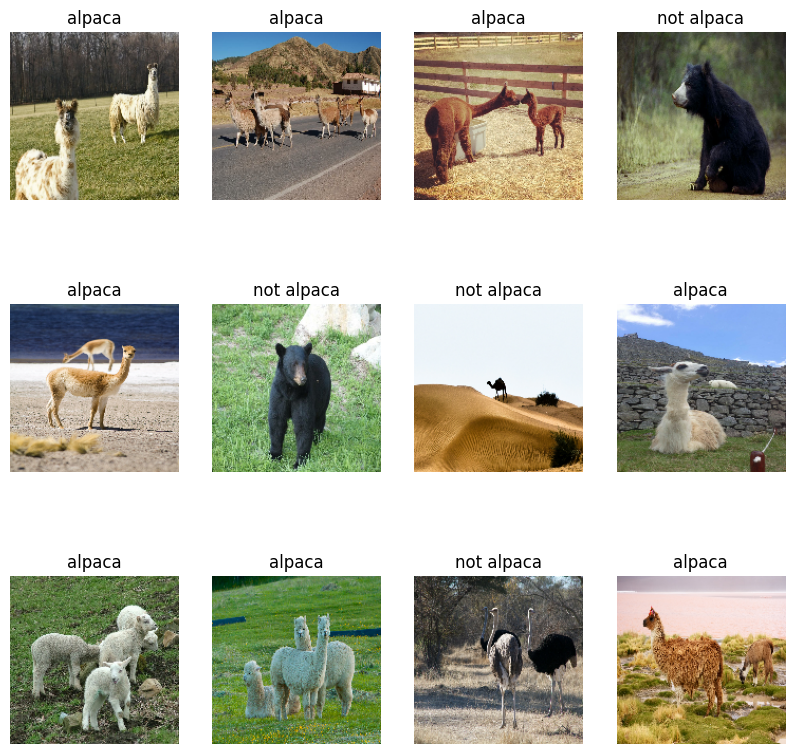

In [3]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):    # take the first batch of images and labels from the training dataset
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## Preprocess and Augment Training Data

`dataset.prefetch` is an important extra step in data preprocessing. Using `prefetch()` prevents a memory bottleneck that can occur when reading from disk. It sets aside some data and keeps it ready for when it's needed, by creating a source dataset from input data, applying a transformation to preprocess it, then iterating over the dataset one element at a time. Because the iteration is streaming, the data doesn't need to fit into memory.

We can set the number of elements to prefetch manually, or use `tf.data.experimental.AUTOTUNE` to choose the parameters automatically. Autotune prompts `tf.data` to tune that value dynamically at runtime, by tracking the time spent in each operation and feeding those times into an optimization algorithm. The optimization algorithm tries to find the best allocation of its CPU budget across all tunable operations. 

To increase diversity in the training set and help our model learn the data better, it's standard practice to augment the images by transforming them, i.e., randomly flipping and rotating them. Keras' Sequential API offers a straightforward method for these kinds of data augmentations, with built-in, customizable preprocessing layers. These layers are saved with the rest of your model and can be re-used later. 

In [4]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [5]:
def data_augmenter():
    """Create a Sequential model composed of 2 layers
    Returns: tf.keras.Sequential
    """

    data_augmentation = tf.keras.Sequential([
        RandomFlip("horizontal"),
        RandomRotation(0.2),
    ])
    
    return data_augmentation

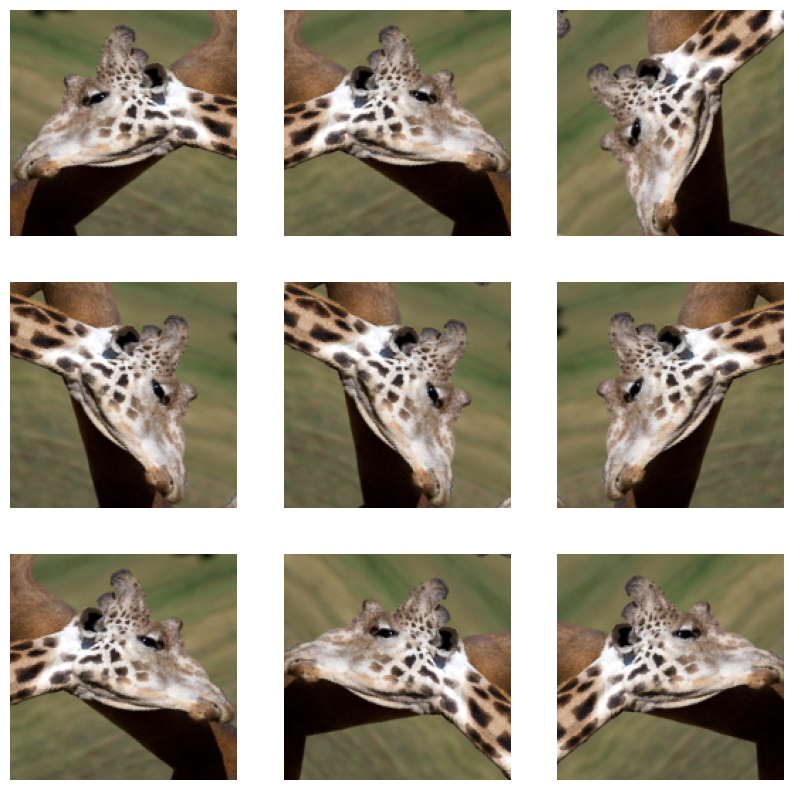

In [6]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))  # add batch dim to image
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

Next, we'll apply your first tool from the MobileNet application in TensorFlow, to normalize the input. Since we're using a pre-trained model that was trained on the normalization values [-1, 1], it's best practice to reuse that standard with `tf.keras.applications.mobilenet_v2.preprocess_input`.

In [7]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

## Using MobileNetV2 for Transfer Learning 

MobileNetV2 was trained on ImageNet and is optimized to run on mobile and other low-power applications. It's 155 layers deep and very efficient for object detection and image segmentation tasks, as well as classification tasks like this one. The architecture has three defining characteristics:

*   Depthwise separable convolutions
*   Thin input and output bottlenecks between layers
*   Shortcut connections between bottleneck layers

### Inside a MobileNetV2 Convolutional Building Block

MobileNetV2 uses depthwise separable convolutions as efficient building blocks. Traditional convolutions are often very resource-intensive, and  depthwise separable convolutions are able to reduce the number of trainable parameters and operations and also speed up convolutions in two steps: 

1. The first step calculates an intermediate result by convolving on each of the channels independently. This is the depthwise convolution.

2. In the second step, another convolution merges the outputs of the previous step into one. This gets a single result from a single feature at a time, and then is applied to all the filters in the output layer. This is the pointwise convolution.

<img src="media/mobilenetv2.png" style="width:650px;height:450px;">
<caption><center> <u> <font color='purple'> <b>Figure 1</b> </font></u><font color='purple'>  : <b>MobileNetV2 Architecture</b></font></center></caption>

Each block consists of an inverted residual structure with a bottleneck at each end. These bottlenecks encode the intermediate inputs and outputs in a low dimensional space, and prevent non-linearities from destroying important information. 

The shortcut connections, which are similar to the ones in traditional residual networks, serve the same purpose of speeding up training and improving predictions. These connections skip over the intermediate convolutions and connect the bottleneck layers. 

Let's try to train a base model using all the layers from the pretrained model.

Similarly to how we reused the pretrained normalization values MobileNetV2 was trained on, we'll also load the pretrained weights from ImageNet by specifying `weights='imagenet'`.

In [8]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=True, weights='imagenet')

14536120/14536120 [==============================] - 3s 0us/step


In [10]:
# base_model.summary()

## Total params: 3538984 (13.50 MB)
## Trainable params: 3504872 (13.37 MB)
## Non-trainable params: 34112 (133.25 KB)

Note the last 2 layers here. They are the so called top layers, and they are responsible of the classification in the model

In [11]:
nb_layers = len(base_model.layers)
print(base_model.layers[nb_layers - 2].name)
print(base_model.layers[nb_layers - 1].name)

global_average_pooling2d
predictions


Next, choose the first batch from the tensorflow dataset to use the images, and run it through the MobileNetV2 base model to test out the predictions on some of our images. 

In [12]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 1000)


32 refers to the batch size and 1000 refers to the 1000 classes the model was trained on. Let's decode the predictions to human-readable format.

In [13]:
label_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 0, 0])>

In [14]:
base_model.trainable = False
image_var = tf.Variable(preprocess_input(image_batch))
pred = base_model(image_var)

# the top two probabilities returned for an image are:
tf.keras.applications.mobilenet_v2.decode_predictions(pred.numpy(), top=2)

35363/35363 [==============================] - 0s 0us/step


[[('n02489166', 'proboscis_monkey', 0.10329976),
  ('n02102177', 'Welsh_springer_spaniel', 0.078835905)],
 [('n02125311', 'cougar', 0.16546789), ('n02389026', 'sorrel', 0.10764301)],
 [('n02437312', 'Arabian_camel', 0.29232776),
  ('n02437616', 'llama', 0.27713513)],
 [('n03944341', 'pinwheel', 0.31155023), ('n03047690', 'clog', 0.05250005)],
 [('n02454379', 'armadillo', 0.7310714), ('n01990800', 'isopod', 0.03872014)],
 [('n02437312', 'Arabian_camel', 0.25663656),
  ('n02422106', 'hartebeest', 0.12122733)],
 [('n02437616', 'llama', 0.6612556),
  ('n02090721', 'Irish_wolfhound', 0.2378285)],
 [('n02133161', 'American_black_bear', 0.8273564),
  ('n02134418', 'sloth_bear', 0.029259508)],
 [('n01518878', 'ostrich', 0.9267561),
  ('n02002724', 'black_stork', 0.001776633)],
 [('n01518878', 'ostrich', 0.949546), ('n02018795', 'bustard', 0.0028661625)],
 [('n02437616', 'llama', 0.8699829), ('n02412080', 'ram', 0.07675745)],
 [('n02415577', 'bighorn', 0.24294513), ('n02412080', 'ram', 0.160565

Uh-oh. There's a whole lot of labels here, some of them hilariously wrong, but none of them say "alpaca." This is because MobileNet pretrained over ImageNet doesn't have the correct labels for alpacas, so when we use the full model, all we get is a bunch of incorrectly classified images.

Fortunately, we can delete the top layer, which contains all the classification labels, and create a new classification layer.

### Layer Freezing with the Functional API

Next, we'll see how we can use a pretrained model to modify the classifier task so that it's able to recognize alpacas. We can achieve this in three steps: 

1. Delete the top layer (the classification layer)
    * Set `include_top` in `base_model` as False
2. Add a new classifier layer
    * Train only one layer by freezing the rest of the network
    * As mentioned before, a single neuron is enough to solve a binary classification problem
3. Freeze the base model and train the newly-created classifier layer
    * Set `base model.trainable=False` to avoid changing the weights and train *only* the new layer
    * Set training in `base_model` to False to avoid keeping track of statistics in the batch norm layer

In [15]:
def alpaca_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    """Define a tf.keras model for binary classification out of the MobileNetV2 model
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
    Returns:
        tf.keras.model
    """
    
    input_shape = image_shape + (3,)    # add color channel dim
    
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    
    # freeze the base model by making it non trainable
    base_model.trainable = False 

    # create the input layer (same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape) 

    # apply data augmentation to the inputs
    x = data_augmentation(inputs)
    
    # data preprocessing using the same weights the model was trained on
    x = preprocess_input(x)
    
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False)
    
    # add the new Binary classification layers
    # use global avg pooling to summarize the info in each channel
    x = tfl.GlobalAveragePooling2D()(x)
    
    # include dropout with probability of 0.2 to avoid overfitting
    x = tfl.Dropout(0.2)(x)
        
    # use a prediction layer with one neuron (as a binary classifier only needs one)
    outputs = tfl.Dense(1, activation='linear')(x)
    
    model = tf.keras.Model(inputs, outputs)
    return model

In [16]:
model2 = alpaca_model(IMG_SIZE, data_augmentation)

9406464/9406464 [==============================] - 1s 0us/step


In [18]:
# compiling new model and training for 5 epochs

base_learning_rate = 0.001
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
               loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
               metrics=['accuracy'])

In [19]:
initial_epochs = 5
history = model2.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/5
9/9 [==============================] - 5s 300ms/step - loss: 0.7147 - accuracy: 0.5916 - val_loss: 0.6594 - val_accuracy: 0.5077
Epoch 2/5
9/9 [==============================] - 2s 205ms/step - loss: 0.5836 - accuracy: 0.6450 - val_loss: 0.4811 - val_accuracy: 0.6923
Epoch 3/5
9/9 [==============================] - 2s 206ms/step - loss: 0.4866 - accuracy: 0.7786 - val_loss: 0.3937 - val_accuracy: 0.7846
Epoch 4/5
9/9 [==============================] - 2s 207ms/step - loss: 0.4602 - accuracy: 0.7405 - val_loss: 0.3848 - val_accuracy: 0.7385
Epoch 5/5
9/9 [==============================] - 2s 206ms/step - loss: 0.3467 - accuracy: 0.8359 - val_loss: 0.3050 - val_accuracy: 0.8615


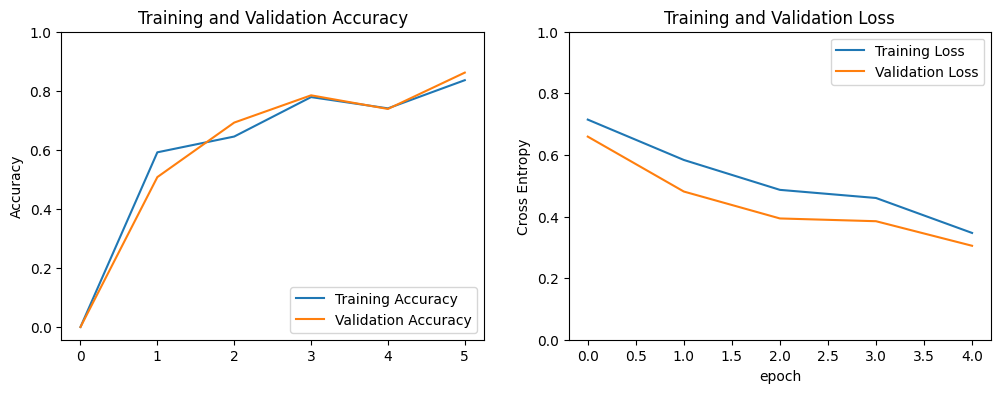

In [24]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 4))

# Plot for Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

# Plot for Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

plt.show()

## Fine-tuning the Model

We could try fine-tuning the model by re-running the optimizer in the last layers to improve accuracy. When we use a smaller learning rate, we take smaller steps to adapt it a little more closely to the new data. In transfer learning, the way we achieve this is by unfreezing the layers at the end of the network, and then re-training the model on the final layers with a very low learning rate. Adapting our learning rate to go over these layers in smaller steps can yield more fine details - and higher accuracy.

**The intuition for what's happening:** when the network is in its earlier stages, it trains on low-level features, like edges. In the later layers, more complex, high-level features like wispy hair or pointy ears begin to emerge. For transfer learning, the low-level features can be kept the same, as they have common features for most images. When we add new data, we generally want the high-level features to adapt to it, which is rather like letting the network learn to detect features more related to our data, such as soft fur or big teeth. 

To achieve this, just unfreeze the final layers and re-run the optimizer with a smaller learning rate, while keeping all the other layers frozen.

Where the final layers actually begin is a bit arbitrary, so feel free to play around with this number a bit. The important takeaway is that the later layers are the part of our network that contain the fine details (pointy ears, hairy tails) that are more specific to our problem.

First, unfreeze the base model by setting `base_model.trainable=True`, set a layer to fine-tune from, then re-freeze all the layers before it. Run it again for another few epochs, and see if the accuracy improved!

In [25]:
model2.layers

In [26]:
base_model = model2.layers[4]
base_model.trainable = True

# let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


In [27]:
# fine-tune from this layer onwards
fine_tune_at = 120

# freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
    
# define a BinaryCrossentropy loss function
loss_function = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# define an Adam optimizer with a learning rate of 0.1 * base_learning_rate
optimizer = tf.keras.optimizers.Adam(0.1 * base_learning_rate)

# use accuracy as evaluation metric
metrics = ['accuracy']

model2.compile(loss=loss_function, optimizer=optimizer, metrics=metrics)

In [28]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model2.fit(train_dataset, epochs=total_epochs, 
                          initial_epoch=history.epoch[-1], validation_data=validation_dataset)

Epoch 5/10
9/9 [==============================] - 6s 324ms/step - loss: 0.5465 - accuracy: 0.7595 - val_loss: 0.4196 - val_accuracy: 0.6769
Epoch 6/10
9/9 [==============================] - 2s 248ms/step - loss: 0.3499 - accuracy: 0.8244 - val_loss: 0.1855 - val_accuracy: 0.9231
Epoch 7/10
9/9 [==============================] - 2s 248ms/step - loss: 0.2299 - accuracy: 0.8855 - val_loss: 0.1639 - val_accuracy: 0.9385
Epoch 8/10
9/9 [==============================] - 2s 252ms/step - loss: 0.1898 - accuracy: 0.9198 - val_loss: 0.1457 - val_accuracy: 0.9538
Epoch 9/10
9/9 [==============================] - 2s 254ms/step - loss: 0.1450 - accuracy: 0.9466 - val_loss: 0.0896 - val_accuracy: 0.9846
Epoch 10/10
9/9 [==============================] - 2s 255ms/step - loss: 0.0954 - accuracy: 0.9733 - val_loss: 0.0907 - val_accuracy: 0.9692


In [29]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

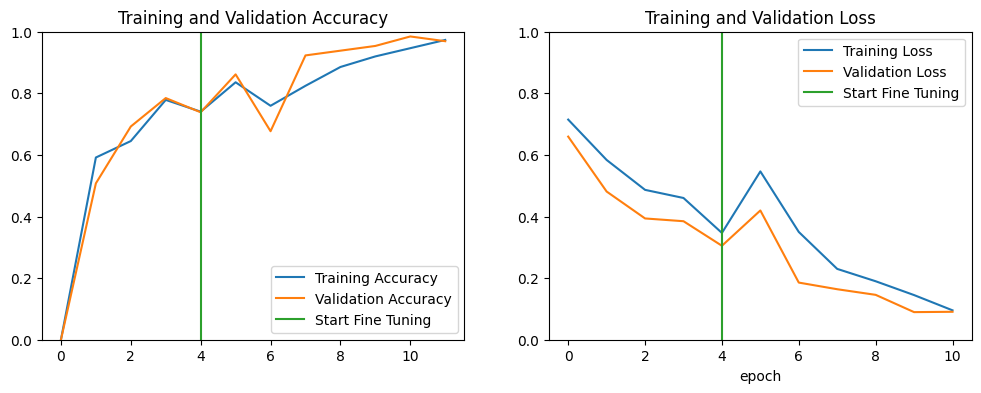

In [30]:
plt.figure(figsize=(12, 4))

# Plot for Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot for Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

plt.show()